In [29]:
%%capture
!pip install pingouin
!pip install researchpy

# Data Analysis Reporting Tool
## Resumo Geral do Dado

In [30]:
import os
import sys
import glob
import warnings
import numpy as np
import seaborn as sns
import pingouin as pg
import researchpy as rpy
from myst_nb import glue
from ipywidgets import widgets
from ipywidgets import interact, interactive, fixed
from collections import OrderedDict
from IPython.display import display

from global_configurations import *

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

DATASET_INFO_PATH = glob.glob(os.path.join(DATASET_PATH, '*.yaml'))[0]
conf_dict = read_config_file(DATASET_INFO_PATH)
df = read_dataset(conf_dict, DATASET_PATH)

df, numerical, categorical, categorical_dt, datetime, identifier, target = infer_column_types(df, conf_dict)

### Dimensão dos dados (linhas, colunas)

In [9]:
rows, columns = df[numerical + categorical + datetime + identifier + [target]].shape
glue("rows", rows)
glue("columns", columns)

617531

57

### Inferir tipos das variáveis

In [10]:
variable_types = pd.DataFrame({'Identificadores': [', '.join(identifier)],
                               'Numéricas': [', '.join(numerical)],
                               'Categóricas': [', '.join(categorical)], 
                               'Datas': [', '.join(datetime)],
                               'Alvo':[target]}).T.rename(columns={0: 'Variáveis'})

glue("variable_types", variable_types)

,Variáveis
Identificadores,"cd_lead, cd_lead_origem, cd_proposta_fisica"
Numéricas,"qt_dependente, meta_vendas, nu_total_dia_lead, meta_taxa, meta_leads, qt_vida_cadastro, valor_real_proposta, vl_lead"
Categóricas,"corretor_venda, corretor_lead, supervisor_venda, ds_midia_campanha, ds_nome_fantasia, nm_profissao, ds_grupo_entidade, ds_midia_veiculo, ds_midia_formato, tipo, ds_midia_conteudo, ds_canal_venda, ds_plataforma_lead, nm_operadora, ds_midia_termo, abertura, ds_tabulacao, ds_praca, ds_motivo_quarentena_resumo, ds_status_plataforma, ds_chave_tipo, ds_status_lead, ds_canal_distribuicao_lead, distribuicao, superintendente_venda, status_contrato, ds_segmentacao_lead, ds_tipo_telefone, status_proposta, fl_cliente_ativo, nm_faixa, fl_65_anos, fl_cognitivo, fl_pgto_boleto, fl_quarentena"
Datas,"dt_criacao_lead, dt_distribuicao_lead, dt_limpeza_lead, dt_primeiro_tratamento, dt_quarentena, dt_inicio_contrato, dt_fim_contrato, dt_venda, dt_vigencia, dt_cancelamento"
Alvo,fl_conversao


### Nome e tipo de dado das colunas

In [11]:
column_types = df[numerical+categorical+categorical_dt+[target]]
column_types = column_types.dtypes.to_frame().reset_index().rename(columns={'index': 'Coluna', 0: 'Tipo'})
column_types['Tipo'] = column_types.Tipo.apply(str)
column_types = column_types.groupby('Tipo').agg({'Coluna': lambda x: ', '.join(sorted(x))})
glue("column_types", column_types)

,Coluna
Tipo,
Int64,"dt_cancelamento_day, dt_cancelamento_day_week, dt_cancelamento_hour, dt_cancelamento_minute, dt_cancelamento_month, dt_cancelamento_second, dt_cancelamento_week_number, dt_cancelamento_year, dt_criacao_lead_day, dt_criacao_lead_day_week, dt_criacao_lead_hour, dt_criacao_lead_minute, dt_criacao_lead_month, dt_criacao_lead_second, dt_criacao_lead_week_number, dt_criacao_lead_year, dt_distribuicao_lead_day, dt_distribuicao_lead_day_week, dt_distribuicao_lead_hour, dt_distribuicao_lead_minute, dt_distribuicao_lead_month, dt_distribuicao_lead_second, dt_distribuicao_lead_week_number, dt_distribuicao_lead_year, dt_fim_contrato_day, dt_fim_contrato_day_week, dt_fim_contrato_hour, dt_fim_contrato_minute, dt_fim_contrato_month, dt_fim_contrato_second, dt_fim_contrato_week_number, dt_fim_contrato_year, dt_inicio_contrato_day, dt_inicio_contrato_day_week, dt_inicio_contrato_hour, dt_inicio_contrato_minute, dt_inicio_contrato_month, dt_inicio_contrato_second, dt_inicio_contrato_week_number, dt_inicio_contrato_year, dt_limpeza_lead_day, dt_limpeza_lead_day_week, dt_limpeza_lead_hour, dt_limpeza_lead_minute, dt_limpeza_lead_month, dt_limpeza_lead_second, dt_limpeza_lead_week_number, dt_limpeza_lead_year, dt_primeiro_tratamento_day, dt_primeiro_tratamento_day_week, dt_primeiro_tratamento_hour, dt_primeiro_tratamento_minute, dt_primeiro_tratamento_month, dt_primeiro_tratamento_second, dt_primeiro_tratamento_week_number, dt_primeiro_tratamento_year, dt_quarentena_day, dt_quarentena_day_week, dt_quarentena_hour, dt_quarentena_minute, dt_quarentena_month, dt_quarentena_second, dt_quarentena_week_number, dt_quarentena_year, dt_venda_day, dt_venda_day_week, dt_venda_hour, dt_venda_minute, dt_venda_month, dt_venda_second, dt_venda_week_number, dt_venda_year, dt_vigencia_day, dt_vigencia_day_week, dt_vigencia_hour, dt_vigencia_minute, dt_vigencia_month, dt_vigencia_second, dt_vigencia_week_number, dt_vigencia_year, fl_65_anos, fl_cliente_ativo, fl_cognitivo, fl_conversao, fl_pgto_boleto, fl_quarentena, nu_total_dia_lead, qt_dependente, qt_vida_cadastro"
float64,"meta_leads, meta_taxa, meta_vendas, valor_real_proposta, vl_lead"
string,"abertura, corretor_lead, corretor_venda, distribuicao, ds_canal_distribuicao_lead, ds_canal_venda, ds_chave_tipo, ds_grupo_entidade, ds_midia_campanha, ds_midia_conteudo, ds_midia_formato, ds_midia_termo, ds_midia_veiculo, ds_motivo_quarentena_resumo, ds_nome_fantasia, ds_plataforma_lead, ds_praca, ds_segmentacao_lead, ds_status_lead, ds_status_plataforma, ds_tabulacao, ds_tipo_telefone, nm_faixa, nm_operadora, nm_profissao, status_contrato, status_proposta, superintendente_venda, supervisor_venda, tipo"


## Resumo de Qualidade do Dado
### Dados faltantes

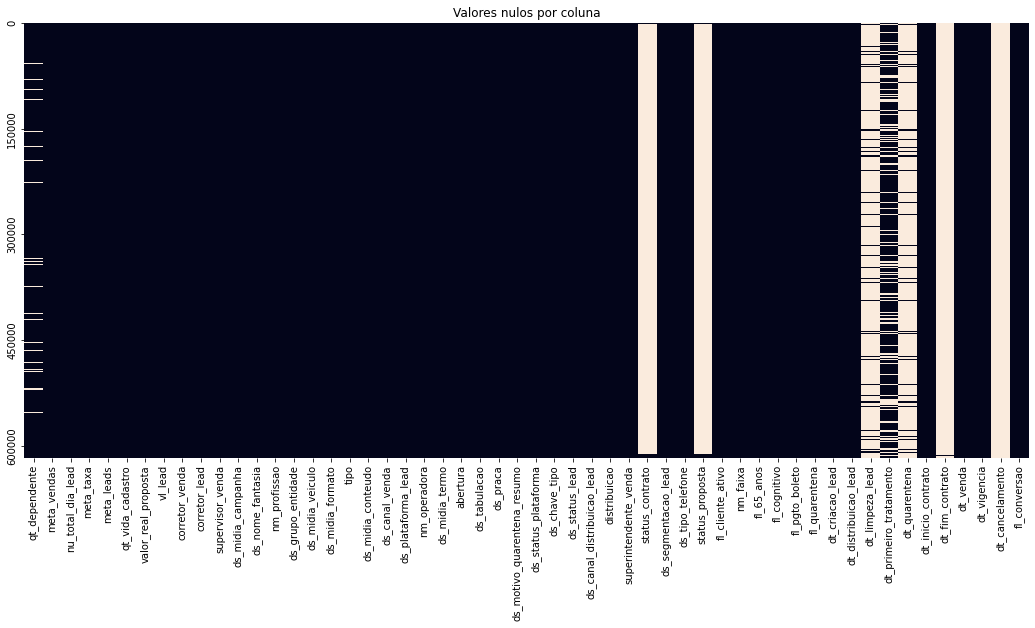

In [2]:
fig = plt.figure(figsize = (18,8))
ax = sns.heatmap(df[numerical + categorical + datetime + [target]].isna(), yticklabels=150000, cbar=False)
ax.set(title='Valores nulos por coluna')

glue("missing_data_plot", fig, display=False)

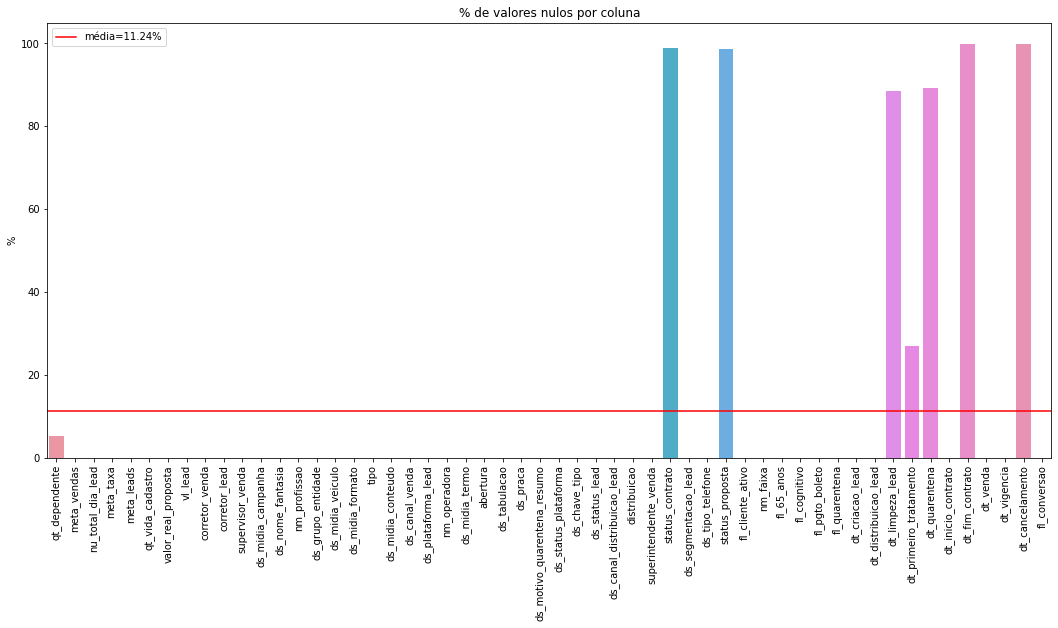

In [3]:
data = df[numerical + categorical + datetime + [target]].isna().sum()/df.shape[0]*100

fig = plt.figure(figsize = (18,8))
ax = sns.barplot(x='index', y=0, data=data.to_frame().reset_index())
ax.set(xlabel='', ylabel='%', title='% de valores nulos por coluna')
ax.tick_params(axis='x', rotation=90)
ax.axhline(data.mean(), 0, 1, color='red', label=f'média={data.mean():.2f}%')
ax.legend()

glue("percent_missing_data_plot", fig, display=False)

In [4]:
has_na_values = ', '.join(data[data>0].index)

glue("has_na_values", has_na_values)

'qt_dependente, status_contrato, status_proposta, dt_limpeza_lead, dt_primeiro_tratamento, dt_quarentena, dt_fim_contrato, dt_cancelamento, fl_conversao'

### Linhas duplicadas

In [5]:
duplicated_rows = df.duplicated().sum()

glue("duplicated_rows", duplicated_rows)

208

## Variável Alvo

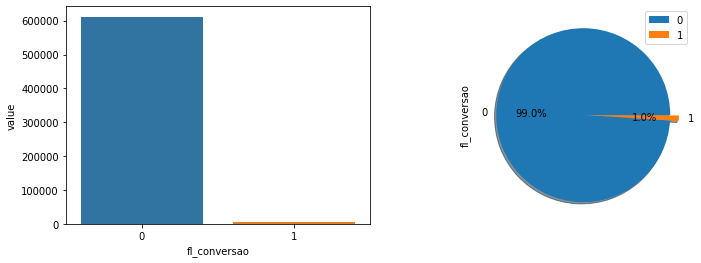

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
data = df[[target]].value_counts().reset_index()
data = data.rename(columns={0: 'value'})

sns.barplot(y='value', x=target, data=data, ax=axes[0])
data.plot.pie(y='value', ax=axes[1], legend=True, autopct='%1.1f%%', 
              explode=(0, 0.1), shadow=True, startangle=0)
axes[1].set(ylabel=target)

glue("target_plot", fig, display=False)

## Variáveis Individuais
### Numéricas

In [14]:
numerical_stats = df[numerical].describe().T.sort_index()

glue("numerical_stats", numerical_stats)

,count,mean,std,min,25%,50%,75%,max
meta_leads,617531.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
meta_taxa,617531.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
meta_vendas,617531.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00
nu_total_dia_lead,617531.0,43.523716,104.366186,-2416.0,22.0,50.0,75.0,226.00
qt_dependente,585610.0,0.054813,0.817324,0.0,0.0,0.0,0.0,156.00
qt_vida_cadastro,617531.0,0.021304,0.205757,0.0,0.0,0.0,0.0,13.00
valor_real_proposta,617531.0,13.096703,158.304564,0.0,0.0,0.0,0.0,15853.20
vl_lead,617531.0,10.277202,157.152401,0.0,0.0,0.0,0.0,33738.18


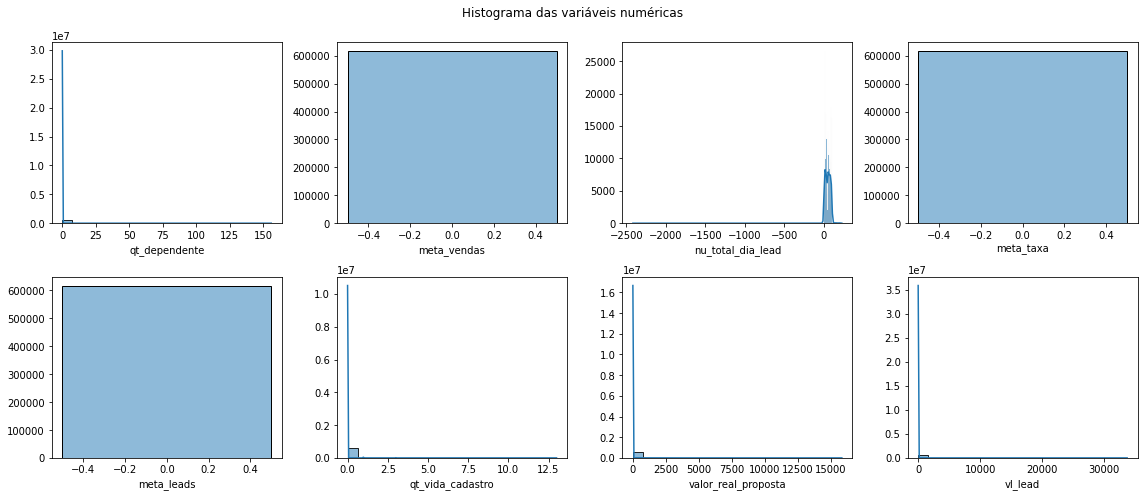

In [15]:
fig = plt.figure(figsize = (16, 7))

for idx, var in enumerate(numerical, 1):
    ax = fig.add_subplot(2, 4, idx)
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set(ylabel='')
    
fig.suptitle('Histograma das variáveis numéricas')
fig.tight_layout()

glue("numerical_hist_plot", fig, display=False)

In [17]:
# TODO: QQPlot para variáveis numéricas

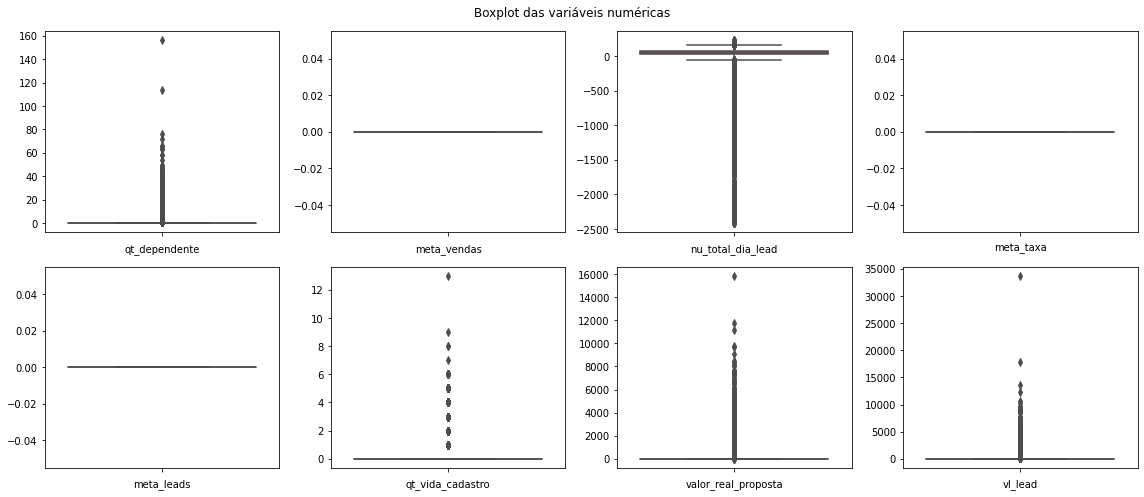

In [16]:
fig = plt.figure(figsize = (16, 7))

for idx, var in enumerate(numerical, 1):
    ax = fig.add_subplot(2, 4, idx)
    sns.boxplot(y=var, data=df[[var]], ax=ax, palette='flare')
    ax.set(ylabel='', xlabel=var)
    
fig.suptitle('Boxplot das variáveis numéricas')
fig.tight_layout()

glue("numerical_box_plot", fig, display=False)

### Categóricas

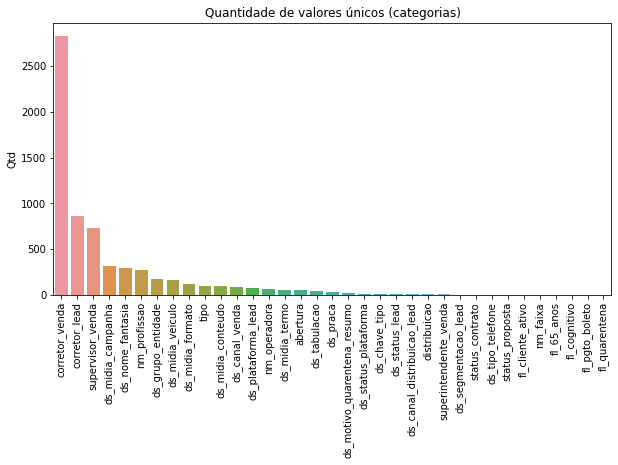

In [18]:
fig = plt.figure(figsize=(10, 5))
data = df[categorical].nunique().to_frame(name='Qtd')
data = data.reset_index().sort_values(by='Qtd', ascending=False)

ax = sns.barplot(y='Qtd', x='index', data=data)
ax.set(xlabel='', title='Quantidade de valores únicos (categorias)')
ax.tick_params(axis='x', rotation=90)

glue("categorical_unique_plot", fig, display=False)

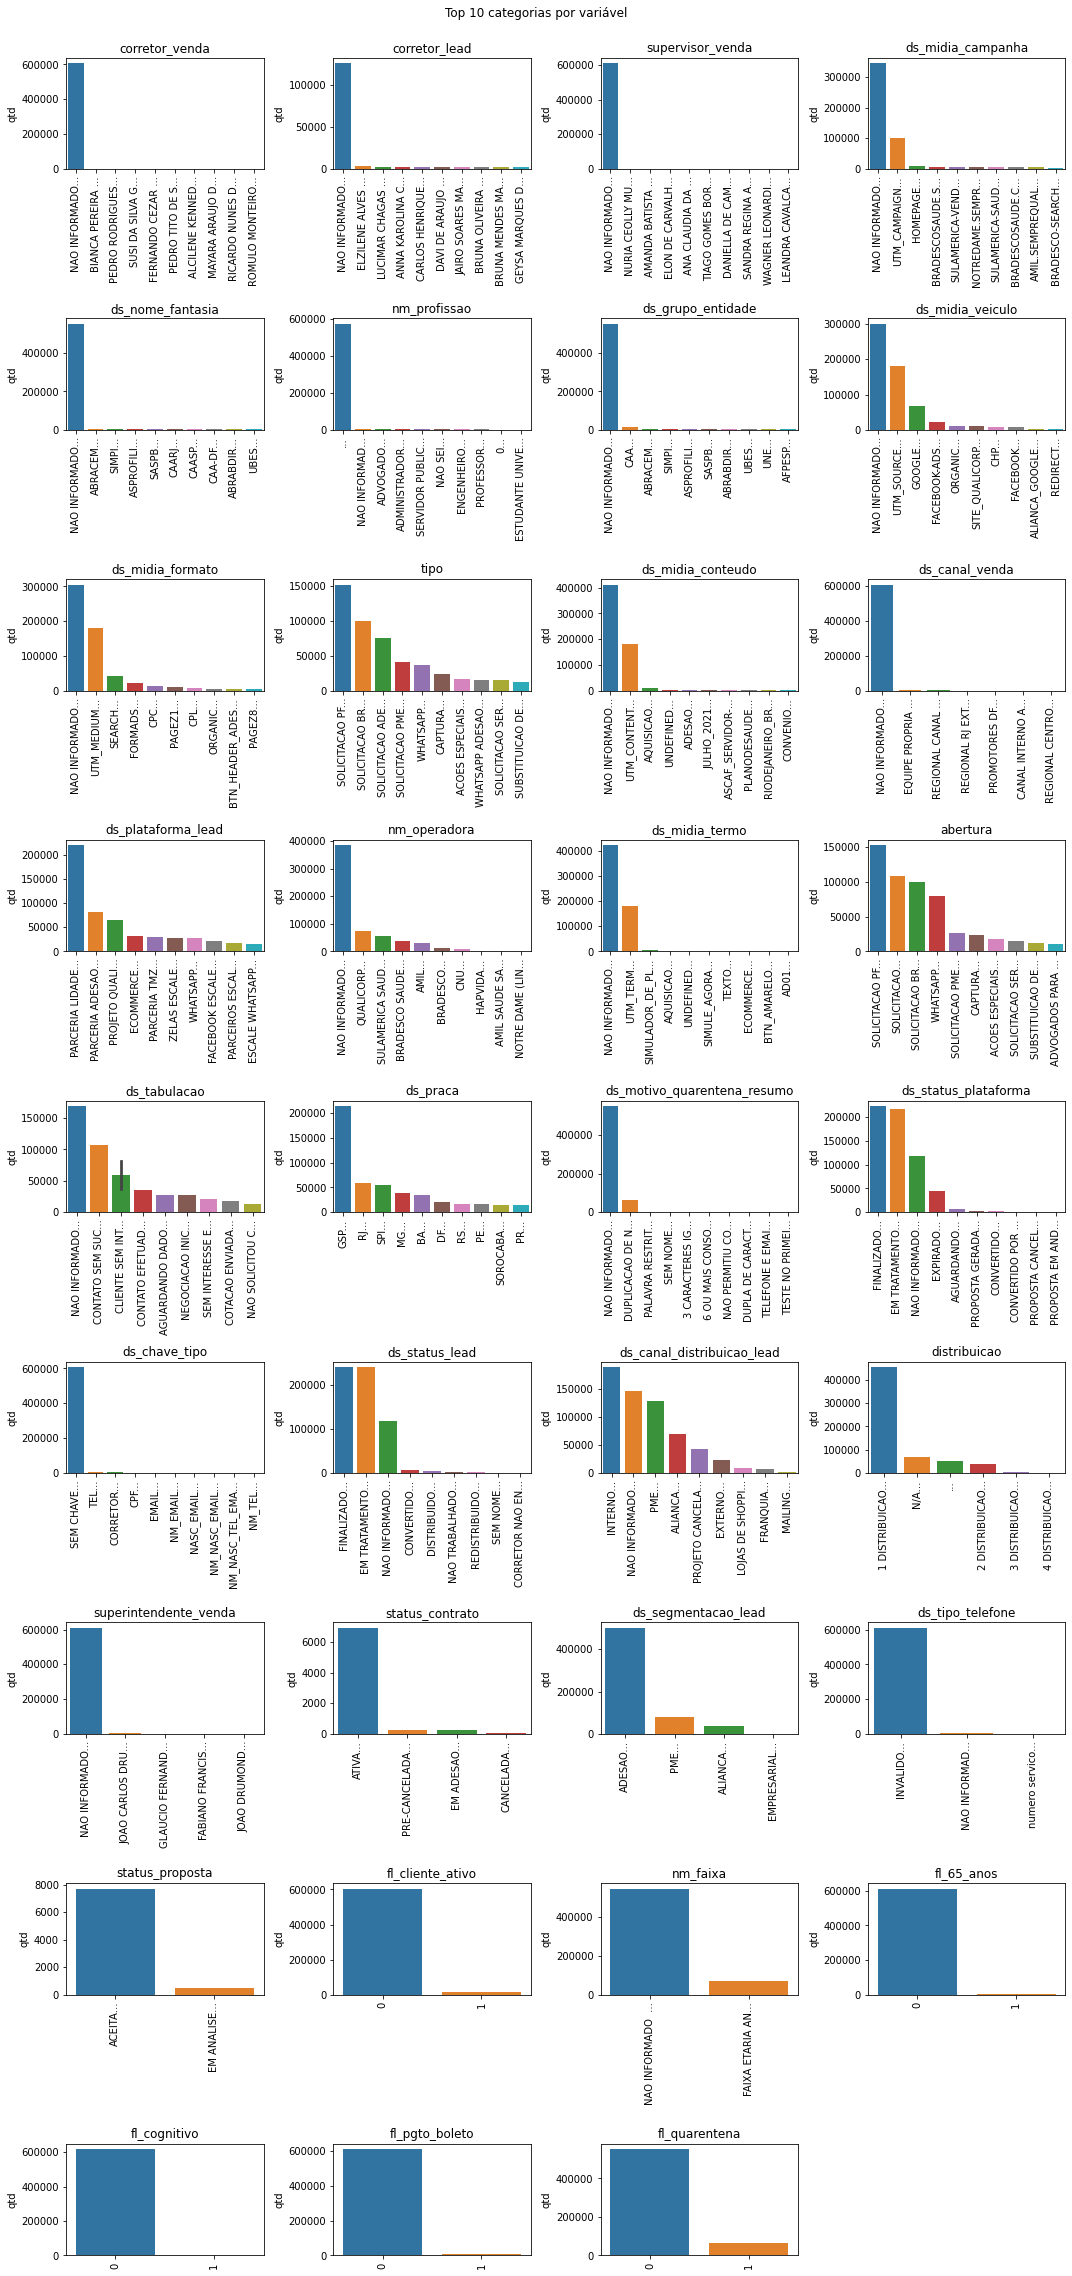

In [19]:
fig = plt.figure(figsize=(15, 35))

for idx, var in enumerate(categorical, 1):
    ax = fig.add_subplot(10, 4, idx)
    data = df[var].value_counts()[:10]
    data = data.to_frame().reset_index()
    data.columns = ['categoria', 'qtd']
    data.categoria = data.categoria.apply(lambda x: f"{x[:15]}..." if isinstance(x, str) else x)
    
    sns.barplot(x='categoria', y='qtd', data=data, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.set(xlabel="", title=var)
    
fig.suptitle('Top 10 categorias por variável', y=1)    
fig.tight_layout()

glue("categorical_top_categories_plot", fig, display=False)

### Data

In [20]:
categorical_year = list(get_datetime_var_names(datetime, 'year'))
categorical_month = list(get_datetime_var_names(datetime, 'month'))
categorical_week_number = list(get_datetime_var_names(datetime, 'week_number'))
categorical_day = list(get_datetime_var_names(datetime, 'day'))
categorical_day_week = list(get_datetime_var_names(datetime, 'day_week'))
categorical_hour = list(get_datetime_var_names(datetime, 'hour'))
categorical_minute = list(get_datetime_var_names(datetime, 'minute'))
categorical_second = list(get_datetime_var_names(datetime, 'second'))

#### Ano

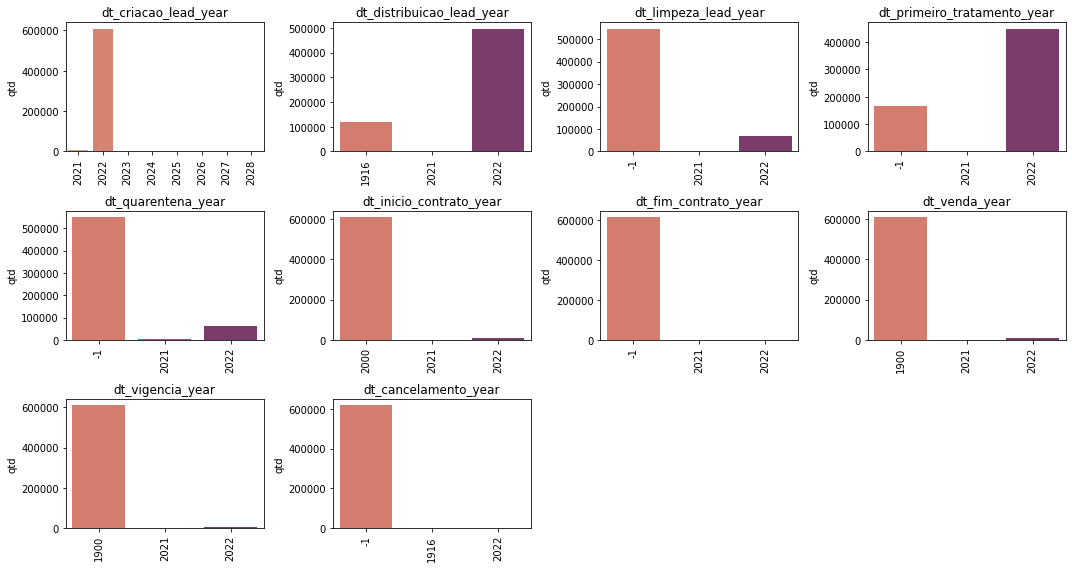

In [21]:
fig = plt.figure(figsize=(15, 8))

for idx, var in enumerate(categorical_year, 1):
    ax = fig.add_subplot(3, 4, idx)
    data = df[var].value_counts()
    data = data.to_frame().reset_index()
    data.columns = ['categoria', 'qtd']
    
    sns.barplot(x='categoria', y='qtd', data=data, ax=ax, palette='flare')
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    ax.set(xlabel="", title=var)

fig.tight_layout()

glue("categoricaldt_year_plot", fig, display=False)

#### Mês

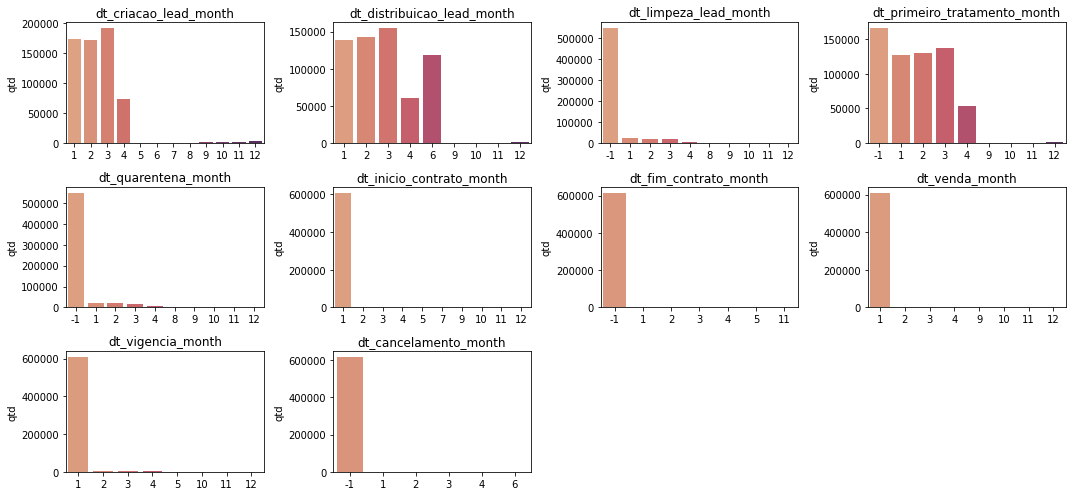

In [22]:
fig = plt.figure(figsize=(15, 7))

for idx, var in enumerate(categorical_month, 1):
    ax = fig.add_subplot(3, 4, idx)
    data = df[var].value_counts()
    data = data.to_frame().reset_index()
    data.columns = ['categoria', 'qtd']
    
    sns.barplot(x='categoria', y='qtd', data=data, ax=ax, palette='flare')
    ax.set(xlabel="", title=var)

fig.tight_layout()

glue("categoricaldt_month_plot", fig, display=False)

#### Semana

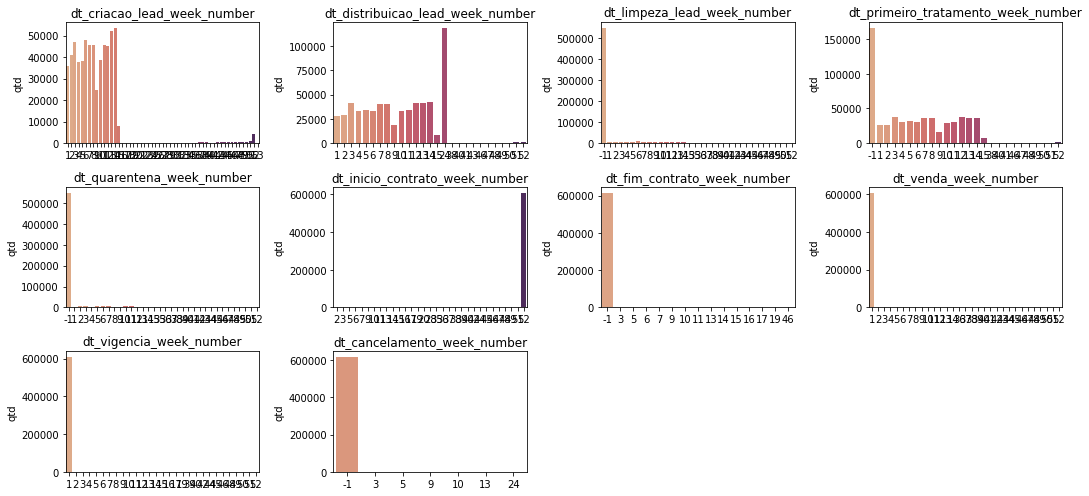

In [23]:
fig = plt.figure(figsize=(15, 7))

for idx, var in enumerate(categorical_week_number, 1):
    ax = fig.add_subplot(3, 4, idx)
    data = df[var].value_counts()
    data = data.to_frame().reset_index()
    data.columns = ['categoria', 'qtd']
    
    sns.barplot(x='categoria', y='qtd', data=data, ax=ax, palette='flare')
    ax.set(xlabel="", title=var)

fig.tight_layout()

glue("categoricaldt_week_plot", fig, display=False)

#### Dia

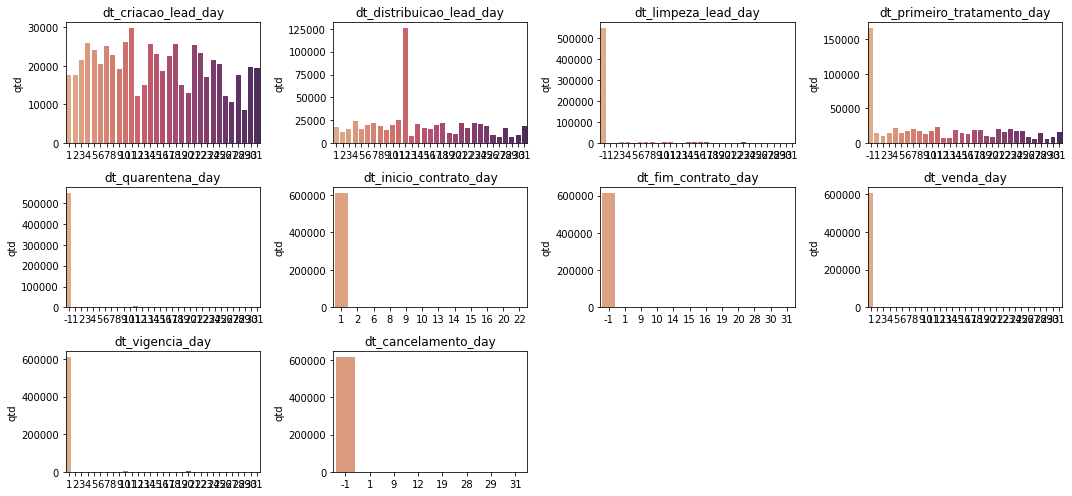

In [24]:
fig = plt.figure(figsize=(15, 7))

for idx, var in enumerate(categorical_day, 1):
    ax = fig.add_subplot(3, 4, idx)
    data = df[var].value_counts()
    data = data.to_frame().reset_index()
    data.columns = ['categoria', 'qtd']
    
    sns.barplot(x='categoria', y='qtd', data=data, ax=ax, palette='flare')
    ax.set(xlabel="", title=var)

fig.tight_layout()

glue("categoricaldt_day_plot", fig, display=False)

#### Dia da semana

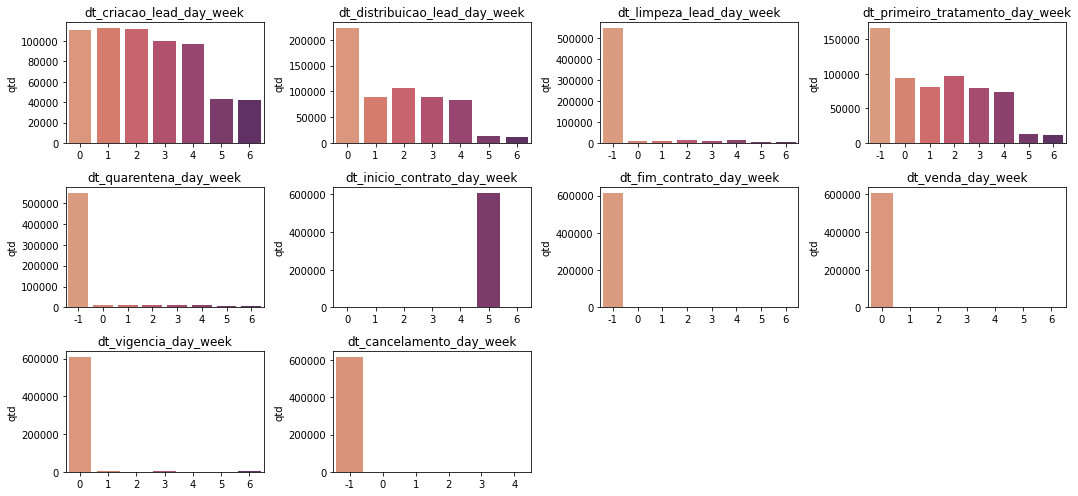

In [25]:
fig = plt.figure(figsize=(15, 7))

for idx, var in enumerate(categorical_day_week, 1):
    ax = fig.add_subplot(3, 4, idx)
    data = df[var].value_counts()
    data = data.to_frame().reset_index()
    data.columns = ['categoria', 'qtd']
    
    sns.barplot(x='categoria', y='qtd', data=data, ax=ax, palette='flare')
    ax.set(xlabel="", title=var)

fig.tight_layout()

glue("categoricaldt_week_day_plot", fig, display=False)

#### Hora

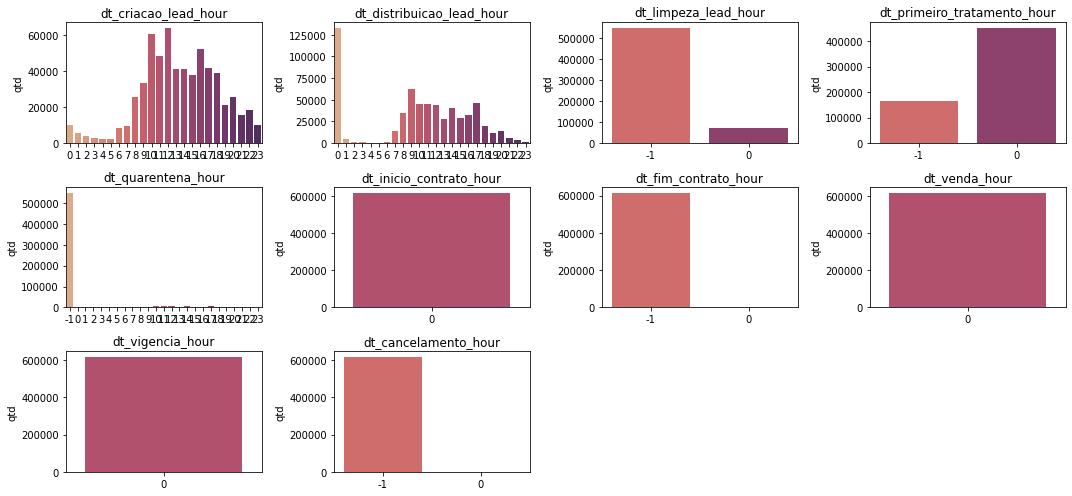

In [26]:
fig = plt.figure(figsize=(15, 7))

for idx, var in enumerate(categorical_hour, 1):
    ax = fig.add_subplot(3, 4, idx)
    data = df[var].value_counts()
    data = data.to_frame().reset_index()
    data.columns = ['categoria', 'qtd']
    
    sns.barplot(x='categoria', y='qtd', data=data, ax=ax, palette='flare')
    ax.set(xlabel="", title=var)

fig.tight_layout()

glue("categoricaldt_hour_plot", fig, display=False)

#### Minuto

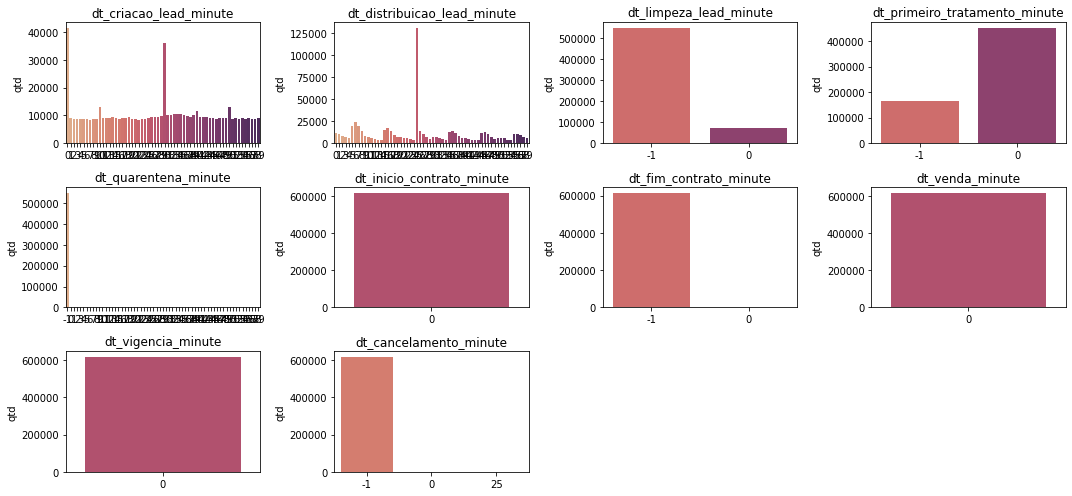

In [27]:
fig = plt.figure(figsize=(15, 7))

for idx, var in enumerate(categorical_minute, 1):
    ax = fig.add_subplot(3, 4, idx)
    data = df[var].value_counts()
    data = data.to_frame().reset_index()
    data.columns = ['categoria', 'qtd']
    
    sns.barplot(x='categoria', y='qtd', data=data, ax=ax, palette='flare')
    ax.set(xlabel="", title=var)

fig.tight_layout()

glue("categoricaldt_minute_plot", fig, display=False)

#### Segundo

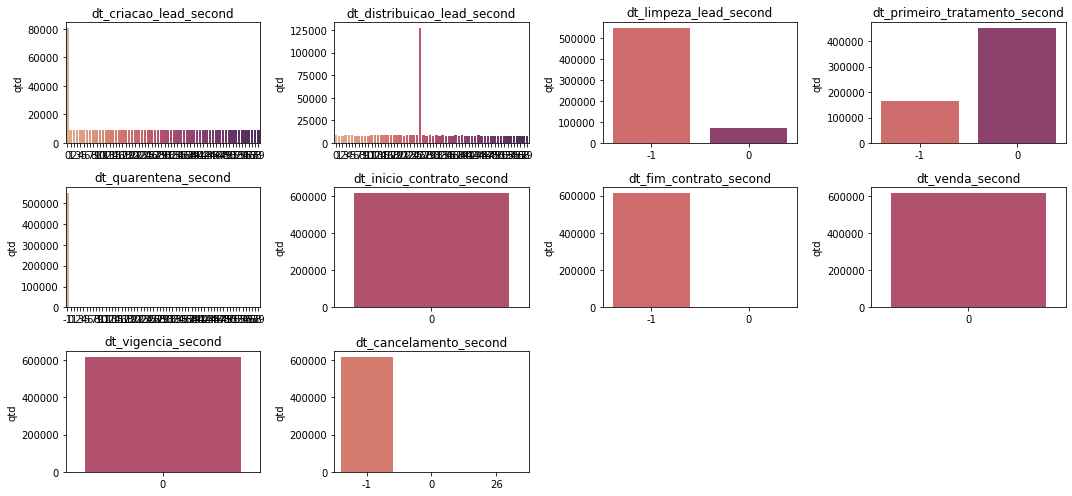

In [28]:
fig = plt.figure(figsize=(15, 7))

for idx, var in enumerate(categorical_second, 1):
    ax = fig.add_subplot(3, 4, idx)
    data = df[var].value_counts()
    data = data.to_frame().reset_index()
    data.columns = ['categoria', 'qtd']
    
    sns.barplot(x='categoria', y='qtd', data=data, ax=ax, palette='flare')
    ax.set(xlabel="", title=var)

fig.tight_layout()

glue("categoricaldt_week_second_plot", fig, display=False)

## Classificação de Variáveis
### Top 40 variáveis numéricas com maior associação com o alvo

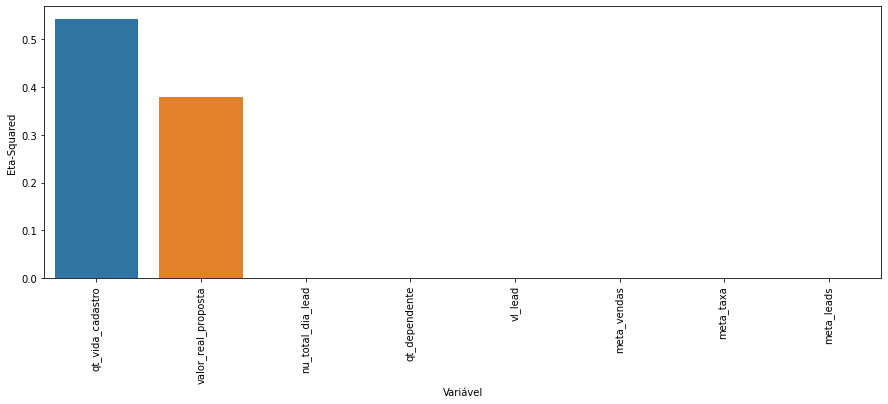

In [31]:
eta_sq = {}
for v in numerical:
    aov = pg.anova(dv=v, between=target, data=df, detailed=True)
    if 'np2' not in aov.columns:
        eta_sq[v] = 0.0
        continue
    eta_sq[v] = aov['np2'][0]
eta_sq = sorted(eta_sq.items(), key=operator.itemgetter(1), reverse=True)

fig = plt.figure(figsize=(15, 5))
ax = sns.barplot(x='Variável', y='Eta-Squared', data=pd.DataFrame(eta_sq, columns=['Variável', 'Eta-Squared']))
ax.tick_params(axis='x', rotation=90)

glue("numerical_eta_sq_plot", fig, display=False)

### Top 40 variáveis categóricas com maior associação com o alvo

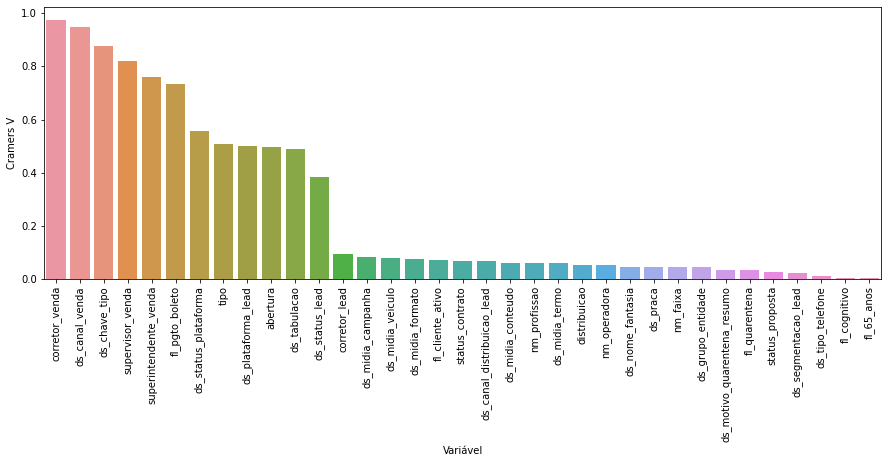

In [32]:
cramers_v = {}
# TODO Identifier variables
for var in categorical:
    crosstab, res = rpy.crosstab(df[target], 
                                 df[var], test='chi-square')
    cramers_v[var] = res['results'][2]
cramers_v = sorted(cramers_v.items(), key=operator.itemgetter(1), reverse=True)

fig = plt.figure(figsize=(15, 5))
ax = sns.barplot(x='Variável', y='Cramers V', data=pd.DataFrame(cramers_v, columns=['Variável', 'Cramers V']).iloc[:40])
ax.tick_params(axis='x', rotation=90)

glue("categorical_cramers_v_plot", fig, display=False)

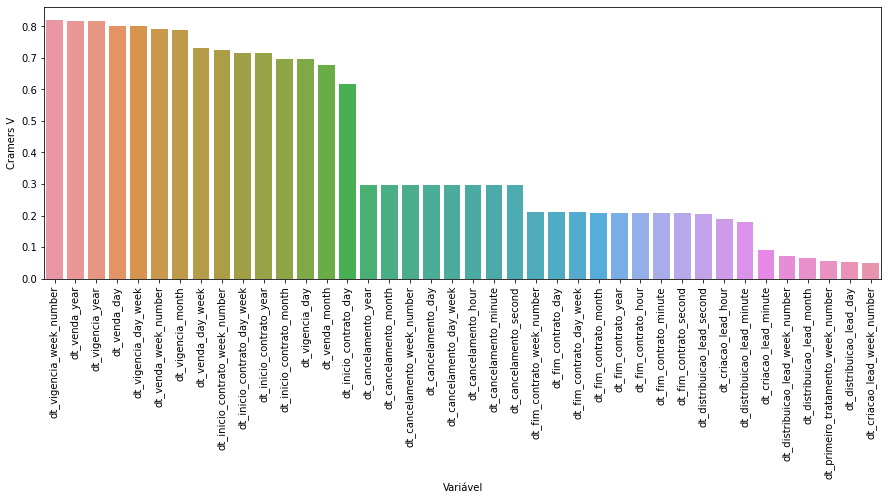

In [33]:
cramers_v = {}
# TODO Identifier variables
if len(categorical_dt) > 0:
    for var in categorical_dt:
        crosstab, res = rpy.crosstab(df[target], 
                                     df[var], test='chi-square')
        cramers_v[var] = res['results'][2]
    cramers_v = sorted(cramers_v.items(), key=operator.itemgetter(1), reverse=True)

    fig = plt.figure(figsize=(15, 5))
    ax = sns.barplot(x='Variável', y='Cramers V', data=pd.DataFrame(cramers_v, columns=['Variável', 'Cramers V']).iloc[:40])
    ax.tick_params(axis='x', rotation=90)

    glue("categorical_dt_cramers_v_plot", fig, display=False)

## Relação entre variável explicavel e de resposta
### Numérica

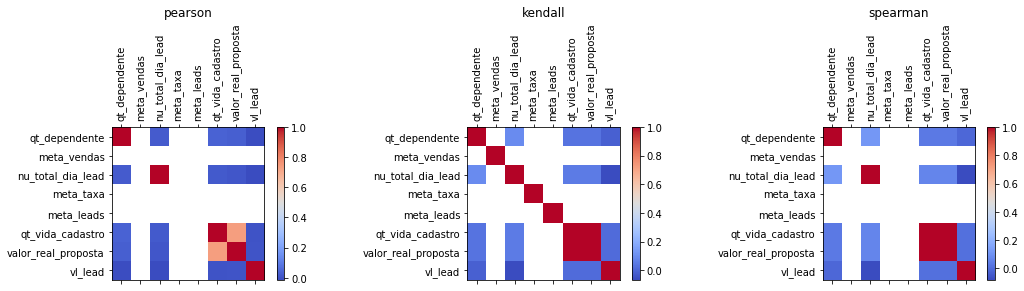

In [6]:
methods = ['pearson', 'kendall', 'spearman']

fig = plt.figure(figsize=(15, 4))
for idx, m in enumerate(methods, 1):
    ax = fig.add_subplot(1, 3, idx)
    correlation_matrix(df[numerical], numerical, m, fig, ax)
    ax.tick_params(axis='x', rotation=90)
    ax.set(title=m)
fig.tight_layout()

glue("numerical_corr_matrix_plot", fig, display=False)

In [7]:
# TODO: Explicar a relação entre as variáveis com regressão linear
def scatter_plot(data, x, y, target):
    fig, ax = plt.subplots(1)
    cols = [x] if x == y else [x, y]
    data = data[cols + [target]].fillna(0)
    return sns.scatterplot(data=data, x=x, y=y, ax=ax, hue=target)

w1, w2 = None, None

cols_list = numerical
    
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Variável 1:'
)
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[1],
    description='Variável 2:'
)

i = interactive(scatter_plot, data=fixed(df), x=w1, y=w2, target=fixed(target))
hbox = widgets.HBox(i.children)
display(hbox)

### Categórica

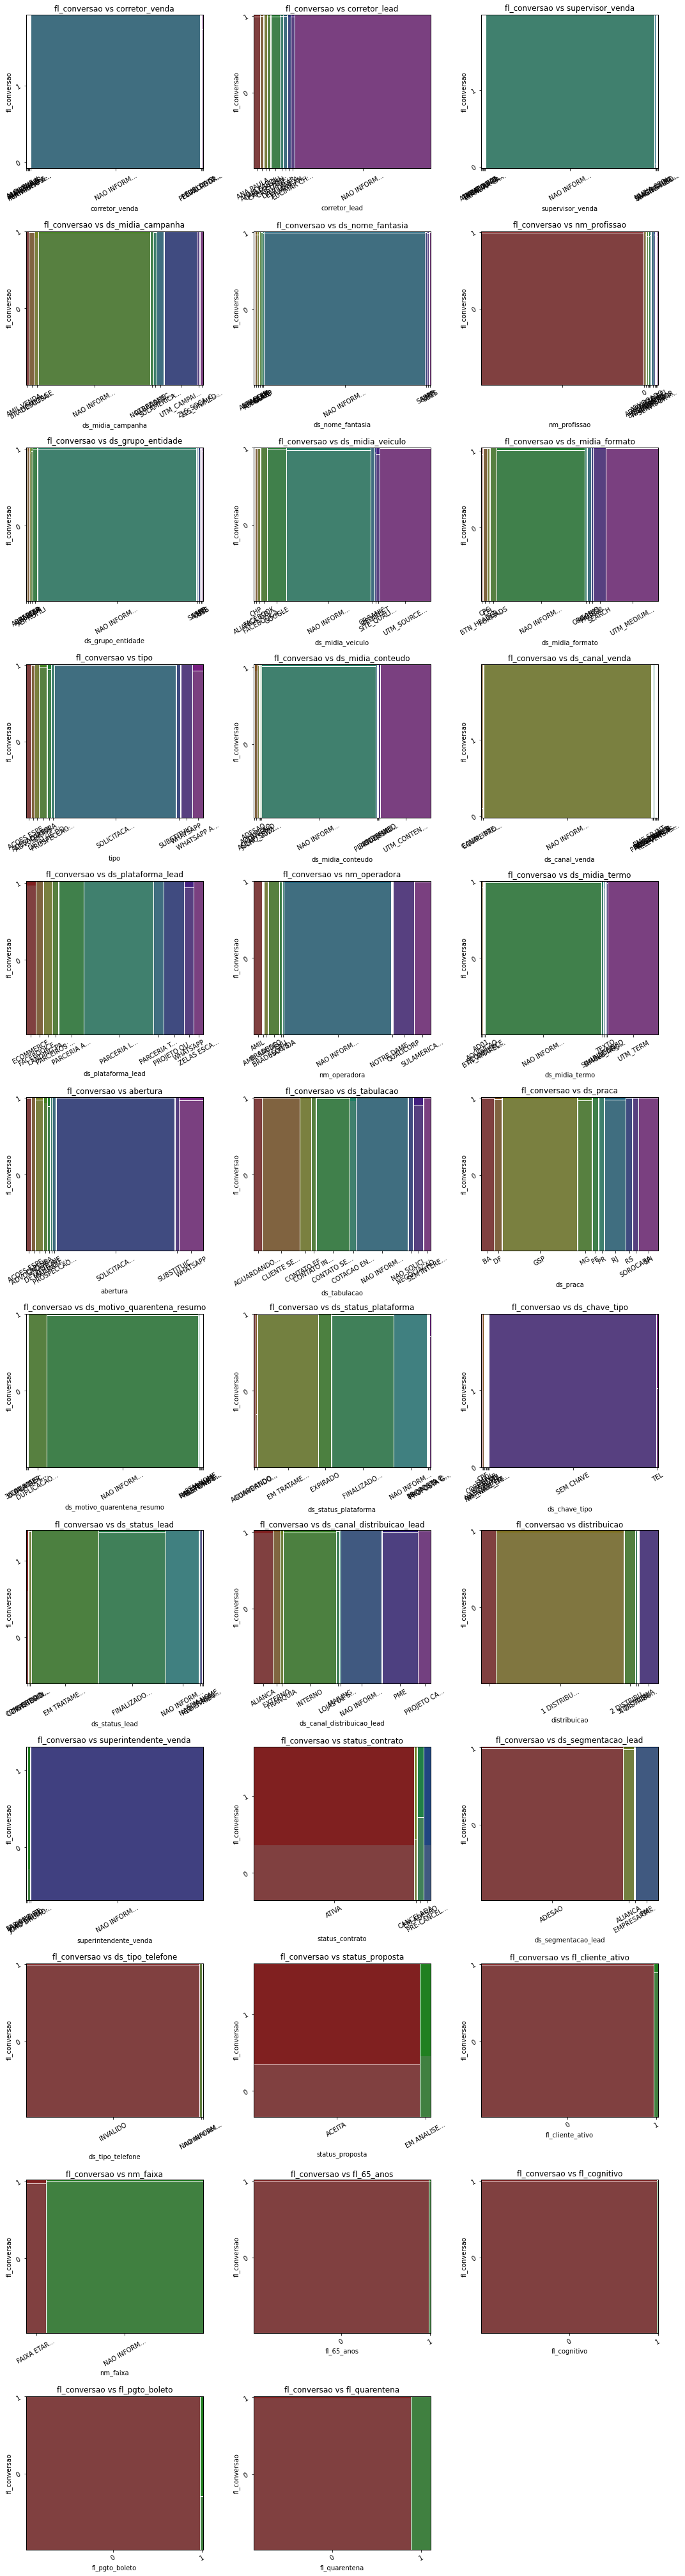

In [8]:
fig = plt.figure(figsize=(15, 65))

def supress_category_label(lbl, size=10):
    if not isinstance(lbl, str):
        return lbl
    if len(lbl) < size:
        return lbl
    return f"{lbl[:size]}..."

for idx, var in enumerate(categorical, 1):
    ax = fig.add_subplot(14, 3, idx)
    data = df[[target, var]] 
    data[var] = data[var].apply(supress_category_label)
   
    mosaic_plot(data=data, x=target, y=var, ax=ax)

fig.tight_layout()

glue("categorical_mosaic_plot", fig, display=False)

In [ ]:
w1, w2 = None, None

if target:
    cols_list = [target] + categorical 
    cols_list = list(OrderedDict.fromkeys(cols_list)) 
else:
    cols_list = conf_dict['CategoricalColumns']
    
w1 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[0],
    description='Variável 1:'
)
w2 = widgets.Dropdown(
    options=cols_list,
    value=cols_list[1],
    description='Variável 2:'
)

i = interactive(interactive_mosaic_plot, data=fixed(df), x=w1, y=w2)
hbox = widgets.HBox(i.children)
display(hbox)